# Introduction
In this project, we conducted a network analysis using NetworkX library on data gathered biannually by the Department of Mental Health and Hygene (DOHMH) through the civil birth registration, and made accessable to the public via <a href="https://data.cityofnewyork.us/Health/Popular-Baby-Names/25th-nujf" > NYC OPEN DATA </a>. This data details popular baby names in New York City along with information on year of birth, gender, ethnicity, number of babys with that name (count) and the frequency of baby names (rank). We developed a network analysis of this data so that we can better understand the relationship various baby names have with race.

## Data Import & Subsetting
We pull the data from NYC open source API and added the data is stored in a CSV format. Our data has been downloaded using Sodapy. Sodapy is a python client for the Socrata Open Data API. we will perform sertain analysis on our dataset. NYC OpenData was accessed using the Socrata API as below, we created a client connection and store the data in a pandas dataframe.

Write a brief description on how we imported the data
Write a brief description of how you subsetted the data

In [59]:
#import all needed libraries
import networkx as net, pandas as pd, numpy as np, re, matplotlib.pyplot as plt, warnings, seaborn as sns

# import Socrata to pull data
from sodapy import Socrata

#call the first 2000 results from the API
client = Socrata("data.cityofnewyork.us", None)
results = client.get("25th-nujf", limit=2000)

# Convert to pandas DataFrame and display data
df = pd.DataFrame.from_records(results)
warnings.filterwarnings('ignore')
df.head()

,brth_yr,gndr,ethcty,nm,cnt,rnk
0,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Olivia,136,1
1,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Emma,109,2
2,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Chloe,103,3
3,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Sophia,86,4
4,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Mia,79,5


In [60]:
df.describe()

,brth_yr,gndr,ethcty,nm,cnt,rnk
count,2000,2000,2000,2000,2000,2000
unique,2,2,4,1209,166,97
top,2017,FEMALE,WHITE NON HISPANIC,Avery,10,82
freq,1973,1039,727,6,156,47


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brth_yr  2000 non-null   object
 1   gndr     2000 non-null   object
 2   ethcty   2000 non-null   object
 3   nm       2000 non-null   object
 4   cnt      2000 non-null   object
 5   rnk      2000 non-null   object
dtypes: object(6)
memory usage: 93.9+ KB


In [62]:
#subset data by year 2017
df = df.loc[df['brth_yr'] == '2017']
#subset data by female gender
df = df.loc[df['gndr'] == 'FEMALE']
df.describe()

,brth_yr,gndr,ethcty,nm,cnt,rnk
count,1012,1012,1012,1012,1012,1012
unique,1,1,4,650,108,84
top,2017,FEMALE,WHITE NON HISPANIC,Alyssa,10,68
freq,1012,1012,387,4,89,39


# Network Development & Visualization
Breif about what approach was taken including adding sttributes, nodes and edges

In [63]:
# DO WE HAVE TO KEEP THIS??
#create potential lists for network data creation
#not including year or gender because there were only two types
nm = list(df.nm.unique())
ethcty = list(df.ethcty.unique())
count = list(df.cnt.unique())
rank = list(df.rnk.unique())

In [64]:
#Network with ethnicity as nodes
G = net.Graph()
G = net.from_pandas_edgelist(df, source= 'nm', target='ethcty',edge_attr=True)
#add the attributes
net.set_node_attributes(G, df['rnk'], 'rank')
net.set_node_attributes(G, df['cnt'], 'count')
print(net.info(G))
# Should we add weights?

Name: 
Type: Graph
Number of nodes: 654
Number of edges: 1012
Average degree:   3.0948


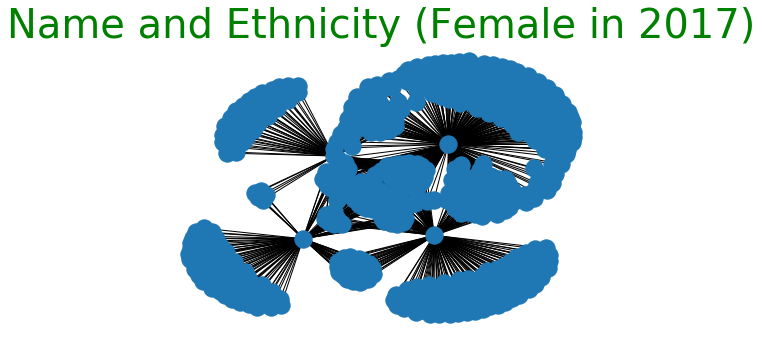

In [76]:
#plot
net.draw(G)
plt.title('Name and Ethnicity (Female in 2017)', fontsize = 40, color = 'Green')
plt.show()

In [66]:
#network is fully connected
# I am interested in the edges that connect the races (common)
net.is_connected(G)

True

In [67]:
net.number_connected_components(G)

1

In [68]:
#print the degree of each node and choose the two largest to subset
ethDeg =  pd.DataFrame(net.degree(G))
#Format column names
ethDeg.rename(columns={0: 'Name',1: 'Degree'}, inplace=True, errors = 'raise')
ethDeg = ethDeg.sort_values(by = 'Degree', ascending=False)
ethDeg.head()

,Name,Degree
435,WHITE NON HISPANIC,387
286,HISPANIC,283
1,ASIAN AND PACIFIC ISLANDER,172
173,BLACK NON HISPANIC,170
47,Victoria,4


## Comments
Write some takewaways after visualizing the data
- what type of network does it seem like
- how does this inform next steps
- what questions does this arise

# Centrality Measures
Centrality measures will be calculated to have understanding of important nodes within the network,and degree of interactions with other nodes. Degree centrality by category(ethnicity) will be calculated as well.

Statistical Analysis on Centrality Measure: With centrality measures calculated on each nodes by category, we can calculate average across these groups and apply t-tests to see if there are statistically significant differences in average degree cewntrality and Eigenvector centrality across ethnic groups.

Breifly describe the centrality measures chosen and what they mean for networks in general

In [69]:
# create dataframe of graph centrality measures
cm = pd.DataFrame()
cm['degree'] = net.degree_centrality(G).values()
cm['betweenness'] = net.betweenness_centrality(G).values()
cm['closeness'] = net.closeness_centrality(G).values()
cm['eigen'] = net.eigenvector_centrality_numpy(G).values() 
cm.index = list(G)

# view centrality measures across boroughs
dat = cm.reset_index()
dat.sort_values('degree' ,ascending = False).head(4)

,index,degree,betweenness,closeness,eigen
435,WHITE NON HISPANIC,0.592649,0.625194,0.552453,0.498479
286,HISPANIC,0.433384,0.383581,0.469784,0.384917
1,ASIAN AND PACIFIC ISLANDER,0.263400,0.179859,0.405087,0.248151
173,BLACK NON HISPANIC,0.260337,0.222691,0.404084,0.204398


In [70]:
network = pd.merge(df, cm, how='inner', left_on = 'ethcty', right_on = cm.index)
network = network[['ethcty', 'nm', 'cnt', 'rnk', 'degree', 'closeness', 'eigen', 'betweenness']]
network.head()

,ethcty,nm,cnt,rnk,degree,closeness,eigen,betweenness
0,ASIAN AND PACIFIC ISLANDER,Olivia,136,1,0.2634,0.405087,0.248151,0.179859
1,ASIAN AND PACIFIC ISLANDER,Emma,109,2,0.2634,0.405087,0.248151,0.179859
2,ASIAN AND PACIFIC ISLANDER,Chloe,103,3,0.2634,0.405087,0.248151,0.179859
3,ASIAN AND PACIFIC ISLANDER,Sophia,86,4,0.2634,0.405087,0.248151,0.179859
4,ASIAN AND PACIFIC ISLANDER,Mia,79,5,0.2634,0.405087,0.248151,0.179859


## Comments
Add some insight into these centrality measures and what they are telling you
**MAYBE ADD THE NODE SIZE ADJUSTED GRAOH OF YOUR CHOOSING HERE** (see below)

## Visualizing Centrality Measures
Describe the seaborn library in one sentence and how we are using it to plot
- add comments to code

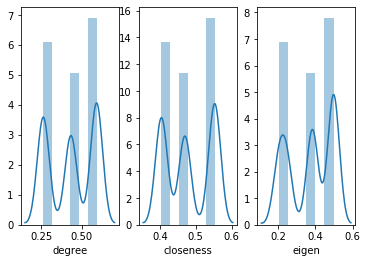

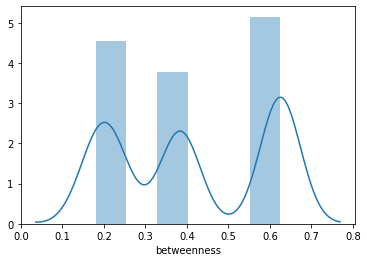

In [73]:
fig, ax = plt.subplots(1, 3)

sns.distplot(network.degree, ax=ax[0])
sns.distplot(network.closeness, ax=ax[1])
sns.distplot(network.eigen, ax=ax[2])

plt.show()

sns.distplot(network.betweenness)
plt.show()

# Node Size Adjusted Plots
We can add some of these centrality measures to our network plot by changing the size of each node depending on each metric.

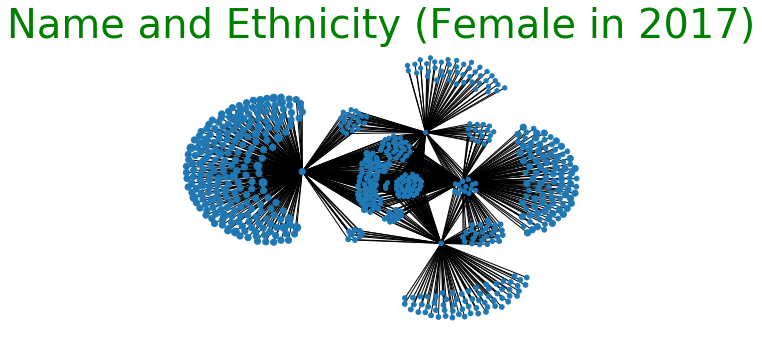

In [75]:
#plot scaled by betweenness centrality
net.draw(G, node_size=[v * 100 for v in list(network.betweenness)])
plt.title('Name and Ethnicity (Female in 2017)', fontsize = 40, color = 'Green')
plt.show()

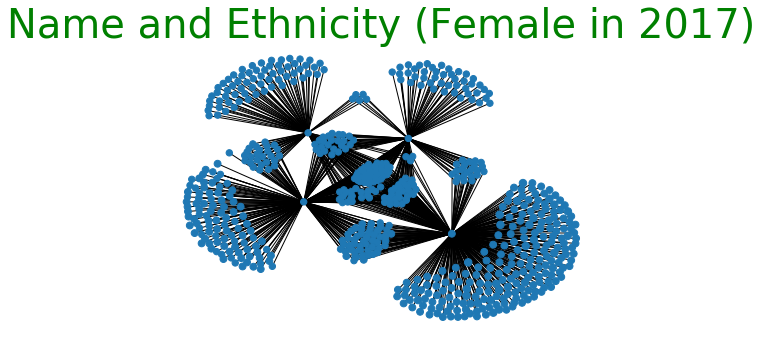

In [77]:
#plot scaled by closeness centrality
net.draw(G, node_size=[v * 100 for v in list(network.closeness)])
plt.title('Name and Ethnicity (Female in 2017)', fontsize = 40, color = 'Green')
plt.show()

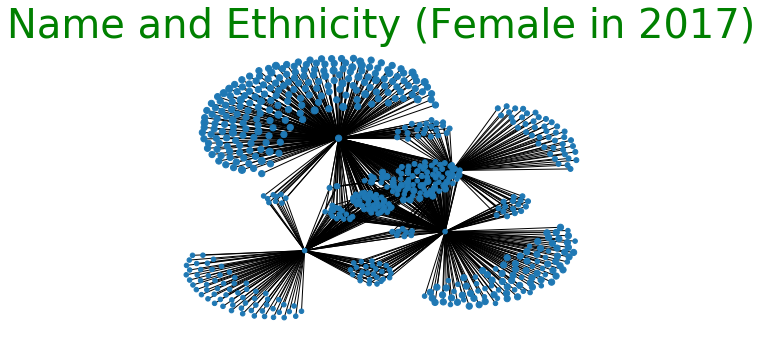

In [79]:
#plot scaled by degree centrality
net.draw(G, node_size=[v * 100 for v in list(network.degree)])
plt.title('Name and Ethnicity (Female in 2017)', fontsize = 40, color = 'Green')
plt.show()

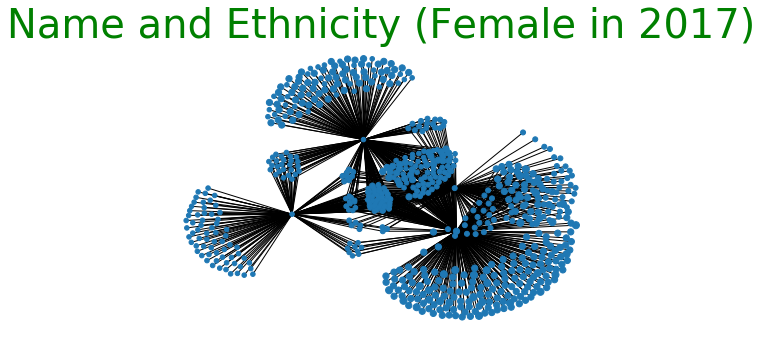

In [80]:
#plot scaled by eigen
net.draw(G, node_size=[v * 100 for v in list(network.eigen)])
plt.title('Name and Ethnicity (Female in 2017)', fontsize = 40, color = 'Green')
plt.show()

# Comparing Centrality Measures
What is the significance of comparing centrality measures? What information can we extract from this?
- add comments to code

In [53]:
# correlation between the measures centrality 
su_df = dat[['degree','betweenness','closeness','eigen']]
su_df.corr()

,degree,betweenness,closeness,eigen
degree,1.000000,0.991768,0.181357,0.909374
betweenness,0.991768,1.000000,0.182292,0.899484
closeness,0.181357,0.182292,1.000000,0.566821
eigen,0.909374,0.899484,0.566821,1.000000


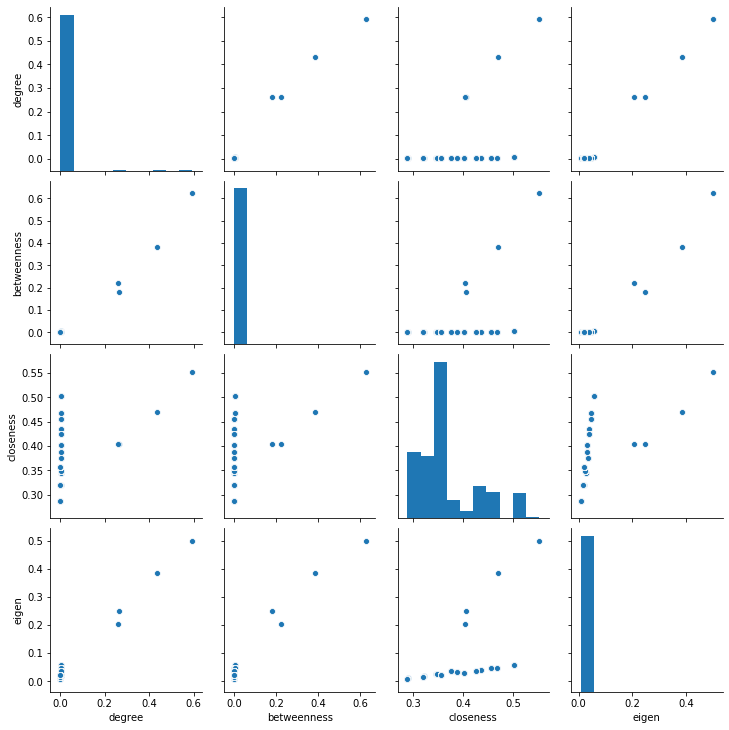

In [54]:
sns.pairplot(dat)

In [81]:
grouped=network.groupby(['ethcty'], as_index='ethcty').mean()[['degree', 'betweenness', 'closeness', 'eigen']]
grouped

,degree,betweenness,closeness,eigen
ethcty,,,,
ASIAN AND PACIFIC ISLANDER,0.263400,0.179859,0.405087,0.248151
BLACK NON HISPANIC,0.260337,0.222691,0.404084,0.204398
HISPANIC,0.433384,0.383581,0.469784,0.384917
WHITE NON HISPANIC,0.592649,0.625194,0.552453,0.498479


# Conclusions
- We need to write this section

# Other stuff I tried and didnt want to delete

In [82]:
array = ['WHITE NON HISPANIC', 'HISPANIC']
whiteHisp  = df.loc[df['ethcty'].isin(array)]
whiteHisp.head()

,brth_yr,gndr,ethcty,nm,cnt,rnk
342,2017,FEMALE,HISPANIC,Mia,250,1
343,2017,FEMALE,HISPANIC,Isabella,245,2
344,2017,FEMALE,HISPANIC,Emma,222,3
345,2017,FEMALE,HISPANIC,Sophia,214,4
346,2017,FEMALE,HISPANIC,Camila,178,5


In [83]:
whiteHisp.describe()

,brth_yr,gndr,ethcty,nm,cnt,rnk
count,670,670,670,670,670,670
unique,1,1,2,535,103,84
top,2017,FEMALE,WHITE NON HISPANIC,Mila,10,68
freq,670,670,387,2,57,39


In [84]:
#Network with ethnicity as nodes
G2 = net.Graph()
G2 = net.from_pandas_edgelist(whiteHisp, source= 'nm', target='ethcty',edge_attr=True)
print(net.info(G2))
# Should we add weights?

Name: 
Type: Graph
Number of nodes: 537
Number of edges: 670
Average degree:   2.4953


In [85]:
#network is fully connected
# I am interested in the edges that connect the races (common)
net.is_connected(G2)

True

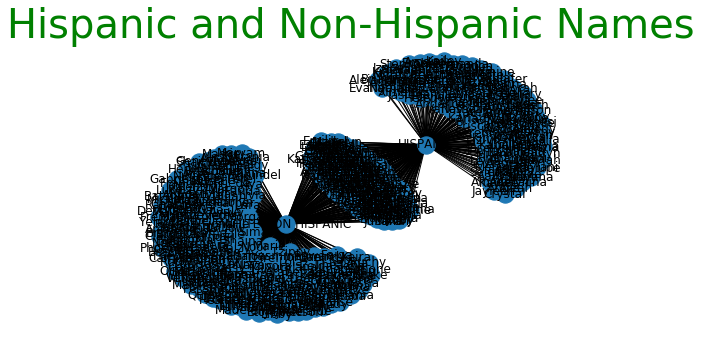

In [34]:
#plot
net.draw(G2, with_labels = True)
plt.title('Hispanic and Non-Hispanic Names', fontsize = 40, color = 'Green')
plt.show()

In [43]:
#print the degree of each node and choose the two largest to subset
whDeg =  pd.DataFrame(net.degree(G2))
#Format column names
whDeg.rename(columns={0: 'Name',1: 'Degree'}, inplace=True, errors = 'raise')
whDeg = whDeg.sort_values(by = 'Degree', ascending=False)
whDeg.head()

,Name,Degree
284,WHITE NON HISPANIC,716
1,HISPANIC,555
0,Mia,2
409,Ryan,2
713,Jackson,2


In [45]:
#select only the ones with 2
whDeg2 = whDeg[whDeg['Degree'] == 2]
whDeg2.describe()

,Degree
count,269.0
mean,2.0
std,0.0
min,2.0
25%,2.0
50%,2.0
75%,2.0
max,2.0


In [46]:
#subset only those names
array2 =list(whDeg2['Name'])
whiteHispConnected  = df.loc[df['nm'].isin(array2)]
whiteHispConnected.head()

,brth_yr,gndr,ethcty,nm,cnt,rnk
0,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Olivia,136,1
1,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Emma,109,2
2,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Chloe,103,3
3,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Sophia,86,4
4,2017,FEMALE,ASIAN AND PACIFIC ISLANDER,Mia,79,5


In [49]:
array2

['Mia',
 'Ryan',
 'Jackson',
 'Israel',
 'Jack',
 'Anderson',
 'Roman',
 'Nolan',
 'Levi',
 'Jonah',
 'Brian',
 'Albert',
 'Charles',
 'Theodore',
 'Hugo',
 'Leon',
 'Gavin',
 'Kai',
 'Louis',
 'Chase',
 'Jaxson',
 'Dylan',
 'Lorenzo',
 'Carter',
 'Dominic',
 'Jaxon',
 'Oscar',
 'Alexis',
 'Robert',
 'Cameron',
 'Antonio',
 'Lukas',
 'Aidan',
 'Richard',
 'Tristan',
 'Martin',
 'Omar',
 'Vincent',
 'Emanuel',
 'Luke',
 'Xander',
 'Marcus',
 'Asher',
 'Zachary',
 'Bianca',
 'Fatima',
 'Liana',
 'Sabrina',
 'Daphne',
 'Anastasia',
 'Alma',
 'Athena',
 'Gia',
 'Anna',
 'Zayn',
 'Sophie',
 'Zara',
 'Sienna',
 'Addison',
 'Celine',
 'Harley',
 'Mackenzie',
 'Madelyn',
 'Everly',
 'Julianna',
 'Audrey',
 'Ayla',
 'Dominick',
 'Saul',
 'Isaiah',
 'Taylor',
 'Amelie',
 'Cecilia',
 'Celeste',
 'Eliza',
 'Annabelle',
 'Lauren',
 'Caroline',
 'Adele',
 'Claire',
 'Amira',
 'Sadie',
 'Esther',
 'Madeline',
 'Owen',
 'George',
 'Brielle',
 'Christopher',
 'Josiah',
 'Oliver',
 'James',
 'Elijah',
 

In [47]:
#visualize the 3rd subsetted network
#Network with ethnicity as nodes
G3 = net.Graph()
G3 = net.from_pandas_edgelist(whiteHispConnected, source= 'nm', target='ethcty',edge_attr=True)
print(net.info(G3))
# Should we add weights?

Name: 
Type: Graph
Number of nodes: 273
Number of edges: 838
Average degree:   6.1392


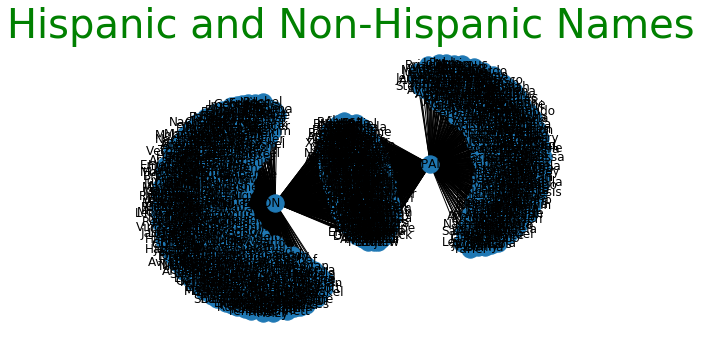

In [48]:
#plot
net.draw(G2, with_labels = True)
plt.title('Hispanic and Non-Hispanic Names', fontsize = 40, color = 'Green')
plt.show()